In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import pandas as pd
import edward as ed
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import networkx as nx

from edward.models import Normal, Poisson, Bernoulli, InverseGamma
from observations import celegans
import collections

In [2]:
#x_train = celegans("~/data")
G = nx.read_edgelist("/Users/oliver/Dropbox/EDU/DTU/Bachelorprojekt Blockchain/Blockchain-Transaction-Classification/Data/network_subset.edgelist", create_using=nx.DiGraph()) # read and parse edgelist to (networkx) graph
A = nx.adjacency_matrix(G) # make Adjacency matrix
x_data = np.asarray(A.todense()) # convert Adjacency matrix to numpy array

In [3]:
x_train = x_data[:500,:500]
x_test = x_data[500:1000,500:1000]

In [2]:
#G=nx.from_numpy_matrix(x_train)
#nx.draw(G, node_size = 5)  # networkx draw()
#plt.draw()
#plt.show()

In [8]:
N = x_train.shape[0]  # number of data points
K = 100  # latent dimensionality

scale_z = InverseGamma(tf.ones([1,K])*1e-3, tf.ones([1,K])*1e-3) 
  
scale_b = InverseGamma(1e-3, 1e-3) #Gelman 2006

z2 = Normal(loc = tf.zeros([N, K]), scale = (tf.sqrt(scale_z)*tf.ones([N, K]))) #Tjek søjle

z1 = Normal(loc = tf.zeros([N, K]), scale = (tf.sqrt(scale_z)*tf.ones([N, K])))
            
b = Normal(loc = tf.zeros(1), scale = (tf.sqrt(scale_b)*tf.ones(1)))


# Calculate N x N distance matrix.
# 1. Create a vector, [||z_1||^2, ||z_2||^2, ..., ||z_N||^2], and tile
# it to create N identical rows.
pi1 = tf.tile(tf.reduce_sum(tf.pow(z1, 2), 1, keepdims=True), [1, N])

pi2 = tf.tile(tf.reduce_sum(tf.pow(z2, 2), 1, keepdims=True), [1, N])        
           
# 2. Create a N x N matrix where entry (i, j) is ||z_i||^2 + ||z_j||^2
# - 2 z_i^T z_j.
pi = pi1 + tf.transpose(pi2) - 2 * tf.matmul(z1, z2, transpose_b=True)
# 3. minus pairwise distances and make rate along diagonals to
# be close to zero.
pi = -tf.sqrt(pi + tf.diag(tf.zeros(N) + 1e3))

pi = tf.sigmoid(pi + b) #med bias (mange eller få links)

x = Bernoulli(pi)

In [4]:
N = x_train.shape[0]  # number of data points
K = 100  # latent dimensionality

#scale_z = InverseGamma(tf.ones([1,K])*1e-3, tf.ones([1,K])*1e-3) 
  
#scale_b = InverseGamma(1e-3, 1e-3) #Gelman 2006

z2 = Normal(loc = tf.zeros([N, K]), scale = tf.ones([N, K]))

z1 = Normal(loc = tf.zeros([N, K]), scale = tf.ones([N, K]))
            
b = Normal(loc = tf.zeros(1), scale = tf.ones(1))


# Calculate N x N distance matrix.
# 1. Create a vector, [||z_1||^2, ||z_2||^2, ..., ||z_N||^2], and tile
# it to create N identical rows.
pi1 = tf.tile(tf.reduce_sum(tf.pow(z1, 2), 1, keepdims=True), [1, N])

pi2 = tf.tile(tf.reduce_sum(tf.pow(z2, 2), 1, keepdims=True), [1, N])        
           
# 2. Create a N x N matrix where entry (i, j) is ||z_i||^2 + ||z_j||^2
# - 2 z_i^T z_j.
pi = pi1 + tf.transpose(pi2) - 2 * tf.matmul(z1, z2, transpose_b=True)
# 3. minus pairwise distances and make rate along diagonals to
# be close to zero.
pi = -tf.sqrt(pi + tf.diag(tf.zeros(N) + 1e3))

pi = tf.sigmoid(pi + b) #med bias (mange eller få links)

x = Bernoulli(pi)

In [1]:
#G=nx.from_numpy_matrix(x.eval())
#nx.draw(G, node_size = 5)  # networkx draw()
#plt.draw()
#plt.show()

In [5]:
inference = ed.MAP([z1,z2,scale_z,scale_b,b], data={x: x_train})
#inference = ed.MAP([z1,z2,b], data={x: x_ph})
#inference = ed.MAP(data={x: x_train})

/anaconda/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/anaconda/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


In [12]:
#tf.reset_default_graph()
qz1 = Normal(loc=tf.get_variable("qz1/loc", [N, K]),
             scale=tf.nn.softplus(tf.get_variable("qz1/scale", [N, K])))
qz2 = Normal(loc=tf.get_variable("qz2/loc", [N, K]),
             scale=tf.nn.softplus(tf.get_variable("qz2/scale", [N, K])))
qb = Normal(loc=tf.get_variable("qb/loc", 1),
             scale=tf.nn.softplus(tf.get_variable("qb/scale", 1)))
qscale_z = Normal(loc=tf.get_variable("qscale_z/loc", [N, K]),
             scale=tf.nn.softplus(tf.get_variable("qscale_z/scale", [N, K])))
qb = Normal(loc=tf.get_variable("qscale_b/loc", 1),
             scale=tf.nn.softplus(tf.get_variable("qscale_b/scale", 1)))

inference = ed.KLqp({z1: qz1, z2: qz2, b: qb}, data={x: x_train})

/anaconda/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/anaconda/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


In [6]:
inference.run(n_iter=2500)

2500/2500 [100%] ██████████████████████████████ Elapsed: 73s | Loss: -341495.094

In [7]:
inference.initialize(n_iter=500,logdir='log')

tf.global_variables_initializer().run()

info_loss = np.zeros(500)


for _ in range(inference.n_iter):
  info_dict = inference.update()
  inference.print_progress(info_dict)
  info_loss[_] = info_dict['loss']

inference.finalize()

500/500 [100%] ██████████████████████████████ Elapsed: 19s | Loss: -227686.906

## Test train different size

In [6]:
optimizer = tf.train.AdamOptimizer(5e-3)
inference.initialize(optimizer=optimizer, var_list=tf.trainable_variables())
#inference.initialize(var_list=tf.trainable_variables())

sess = ed.get_session()
tf.global_variables_initializer().run()

In [13]:
n_epoch = 1000
train_loss = np.zeros(n_epoch)
test_loss = np.zeros(n_epoch)
for i in range(n_epoch):
  info_dict = inference.update(feed_dict={x: x_train})
  train_loss[i] = info_dict['loss']
  test_loss[i] = sess.run(inference.loss, feed_dict={x: x_test})
  inference.print_progress(info_dict)

AttributeError: 'KLqp' object has no attribute 'train'

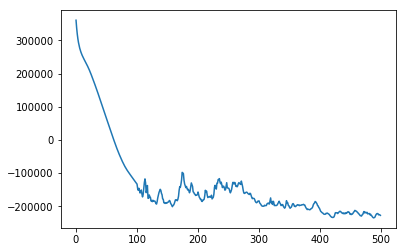

In [9]:
#plt.plot(test_loss)
plt.plot(info_loss)
plt.show()

In [12]:
import seaborn as sns

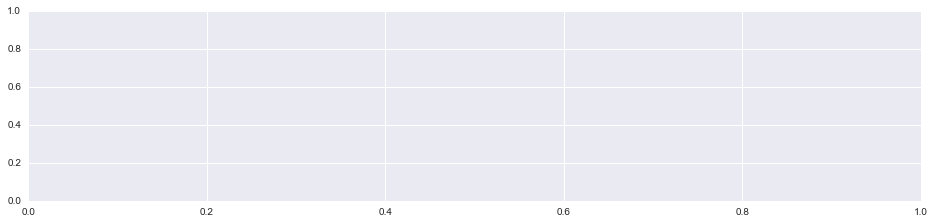

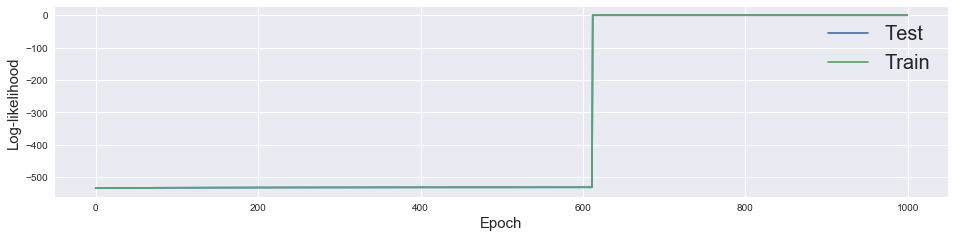

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
plt.plot(np.arange(n_epoch), -test_loss / len(x_test), label='Test')
plt.plot(np.arange(n_epoch), -train_loss / len(x_train), label='Train')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Log-likelihood', fontsize=15)
plt.show()